## 数据

In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [3]:
prostate = pd.read_csv("../../../datasets/prostate/prostate.data", 
                       sep="\t", index_col=0)
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [4]:
train_data = prostate.drop("train", axis=1)[prostate["train"] == "T"]
test_data = prostate.drop("train", axis=1)[prostate["train"] == "F"]

scaler = StandardScaler()
scaler.fit(train_data)
train_data_std = scaler.fit_transform(train_data)
test_data_std = scaler.transform(test_data)
X_train = train_data_std[:, :-1]
y_train = train_data_std[:, -1]
X_test = test_data_std[:, :-1]
y_test = test_data_std[:, -1]

## 最小角度回归

In [5]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [8]:
class LeastAngleRegression(BaseEstimator, RegressorMixin):
    """
    最小角度回归
    
    参数：
    -----
    normalized: 是否标准化输入矩阵
    
    属性：
    -----
    Beta: 系数
    beta_path: 系数路径
    activte_set: 记录依次添加特征的顺序集合
    """
    def __init__(self, normalized=False):
        self.normalized = normalized
    
    def fit(self, X, y):
        if self.normalized:
            X = (X - X.mean(axis=0)) / np.std(X)
        X = np.c_[np.ones(len(X)), X]
        n, p = X.shape
        cur_pred = y.mean()
        residual = y - cur_pred
        cur_corr = X.T @ residual  # 使用内积代替相关性度量
        j = np.argmax(np.abs(cur_corr), axis=0)  #返回有最大相关度变量的索引
        self.active_set = [j]  # 将有最大相关度变量的索引保存在活跃集9中
        beta = np.zeros(p)  
        sign = np.zeros(p)  # 标记活跃变量
        sign[j] = 1

        self.beta_path = np.zeros((p, p))  # 存储系数路径
        self.beta_path[0] = beta
        for it in range(p):
            residual = y - cur_pred
            corrs = X.T @ residual # 计算各个特征与残差之间的相关度

            X_a = X[:, self.active_set]
            X_a *= sign[self.active_set]

            G_a_inv = np.linalg.inv(X_a.T @ X_a)

            G_a_inv_red_cols = np.sum(G_a_inv, 1)
            A_a = 1 / np.sqrt(np.sum(G_a_inv_red_cols))
            omega = A_a * G_a_inv_red_cols
            equiangular = X_a @ omega 

            cos_angle = X.T @ equiangular # 用内积表示相关性
            gamma = None
            largest_abs_correlation = np.abs(corrs).max()
            if it < p - 1:
                next_j = None
                next_sign = 0
                for j in range(p):
                    if j in self.active_set:
                        continue
                    v0 = (largest_abs_correlation - corrs[j]) / (A_a - cos_angle[j]).item()
                    v1 = (largest_abs_correlation + corrs[j]) / (A_a + cos_angle[j]).item()
                    if v0 > 0 and (gamma is None or v0 < gamma):
                        next_j = j
                        gamma = v0
                        next_sign = 1
                    if v1 > 0 and (gamma is None or v1 < gamma):
                        gamma = v1
                        next_j = j
                        next_sign = -1
            else:
                gamma = largest_abs_correlation / A_a

            sa = X_a
            sb = equiangular * gamma
            sx = np.linalg.lstsq(sa, sb)  # 更新方向
            for i, j in enumerate(self.active_set):
                beta[j] += sx[0][i] * sign[j] # 更新系数，向各自的最小二乘系数移动

            cur_pred = X @ beta
            sign[next_j] = next_sign
            self.active_set.append(next_j)
            if it < p -1:
                self.beta_path[it+1, :] = beta # 将更新后的系数加入系数路径中
                
        self.Beta = self.beta_path[-1]
        self.active_set = self.active_set[:-2] - np.ones(len(self.active_set[:-2]))

        return self    

    def predict(self, X):
        if self.normalized:
            X = (X - X.mean(axis=0)) / np.std(X)
        X = np.c_[np.ones(len(X)), X]
        y_pred = X @ self.Beta
        return y_pred

In [9]:
lar = LeastAngleRegression()
lar.fit(X_train, y_train)

E:\a-soft\Anaconda3\envs\mlproduct\lib\site-packages\ipykernel_launcher.py:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


LeastAngleRegression()

In [10]:
y_pred = lar.predict(X_train)
train_err = mean_squared_error(y_train, y_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.306


In [11]:
y_test_preds = lar.predict(X_test)
test_err = mean_squared_error(y_test, y_test_preds)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.363


In [292]:
lar.Beta

array([ 0.        ,  0.59314448,  0.24229136, -0.11802303,  0.1755303 ,
        0.25634746, -0.2392803 , -0.01731521,  0.22962676])

In [293]:
print("特征依次添加的顺序:{}".format(lar.active_set))

特征依次添加的顺序:[0. 1. 4. 3. 7. 2. 5. 6.]


#### LARs路径

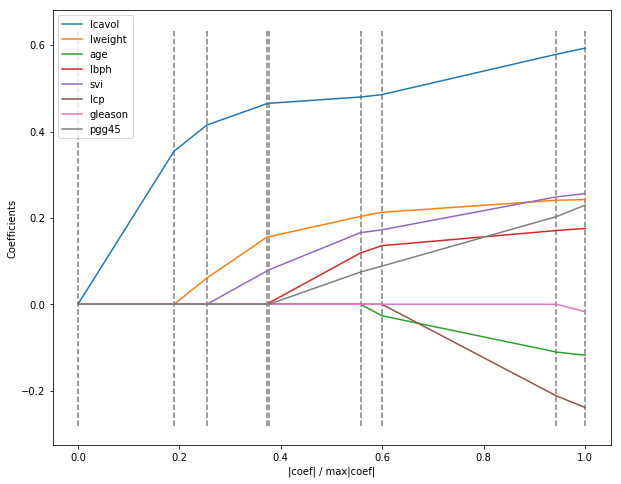

In [305]:
sum_abs_coeff = np.sum(np.abs(lar.beta_path[:, 1:]), 1)
normal_coeff = sum_abs_coeff / sum_abs_coeff[-1]
feature_names = list(train_data.iloc[:, :-1].columns)
p = X_train.shape[1]

plt.figure(figsize=(10, 8))
for i in range(p):
    plt.plot(normal_coeff, lar.beta_path[:, i+1], label=feature_names[i])
ymin, ymax = plt.ylim()
plt.vlines(normal_coeff, ymin, ymax, color='gray', linestyle='--')
plt.legend()
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.show()

### 使用`Sklearn`

In [10]:
from sklearn.linear_model import Lars

In [11]:
sk_lar = Lars(normalize=False)
sk_lar.fit(X_train, y_train)

Lars(normalize=False)

In [12]:
y_train_preds = sk_lar.predict(X_train)
train_err = mean_squared_error(y_train, y_train_preds)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.306


In [13]:
y_test_preds = sk_lar.predict(X_test)
test_err = mean_squared_error(y_test, y_test_preds)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.363


In [18]:
print("特征依次添加的顺序:{}".format(sk_lar.active_))

特征依次添加的顺序:[0, 1, 4, 3, 7, 2, 5, 6]


In [84]:
pd.options.display.float_format = '{:.3f}'.format
coefs = sk_lar.coef_path_.mean(axis=1)
intercept = y_train.mean()
variables = ["Intercept"] + list(train_data.iloc[:, :-1].columns)
pd.DataFrame({"Term": variables, "Coefficient": np.r_[intercept, sk_lar.coef_]})

,Term,Coefficient
0,Intercept,0.000
1,lcavol,0.593
2,lweight,0.242
3,age,-0.118
4,lbph,0.176
5,svi,0.256
6,lcp,-0.239
7,gleason,-0.017
8,pgg45,0.230


#### LAR路径

In [306]:
coef_path = sk_lar.coef_path_
sum_abs_coeff = np.sum(np.abs(coef_path), axis=0)
normal_coeff = sum_abs_coeff / sum_abs_coeff[-1]

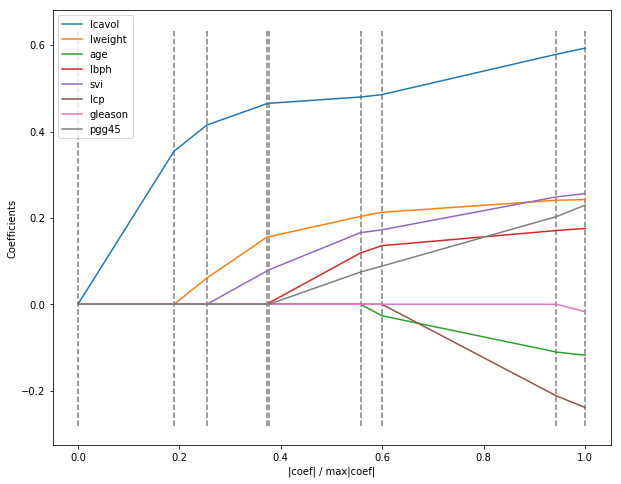

In [307]:
plt.figure(figsize=(10, 8))
for i in range(p):
    plt.plot(normal_coeff, coef_path[i], label=feature_names[i])
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, color='gray', linestyle='--')
plt.legend()
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.show()